In [73]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import ConvexHull
from scipy.stats import norm
import pickle
import os


## Helper Functions for Data Collection

In [74]:
def collect_group_data(hdf5_file, dataset_name):
    group_data_list = []
    
    with h5py.File(hdf5_file, 'r') as f:
        dataset = f[dataset_name]
        group_data = dataset['group'][:]
        x_data = dataset['x'][:]
        y_data = dataset['y'][:]
        
        unique_groups = np.unique(group_data)
        
        for group in unique_groups:
            indices = np.where(group_data == group)
            group_dict = {
                'group': int(group),
                'x': x_data[indices].tolist(),
                'y': y_data[indices].tolist()
            }
            group_data_list.append(group_dict)
    
    return group_data_list

## Clustering Functions

In [75]:
def dbscan_filter(data, eps=0.05, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    core_samples = clustering.core_sample_indices_
    return data.iloc[core_samples]

def find_clusters_k_means(data, k):
    kmeans = KMeans(init="k-means++", n_clusters=k, tol=1e-8, n_init=8, max_iter=1000)
    kmeans.fit(data)
    return kmeans.labels_

def find_com(data, labels):
    com = []
    for i in range(max(labels)+1):
        x = np.mean(data['x'][labels == i])
        y = np.mean(data['y'][labels == i])
        com.append((x, y))
    return com


## Minimum Bounding Rectangles

In [76]:
def minimum_bounding_rectangle(points):
    pi2 = np.pi / 2
    hull_points = points[ConvexHull(points).vertices]
    edges = hull_points[1:] - hull_points[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)
    
    rotations = np.vstack([
        np.cos(angles), np.cos(angles - pi2),
        np.cos(angles + pi2), np.cos(angles)
    ]).T.reshape((-1, 2, 2))

    rot_points = np.dot(rotations, hull_points.T)
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)
    return rval

## Rotation Helper Function

In [77]:
def find_closest_side(mbr):
    """
    Find the index of the side of the minimum bounding rectangle closest to the x-axis.
    """
    sides = [
        (mbr[1] - mbr[0]),
        (mbr[2] - mbr[1]),
        (mbr[3] - mbr[2]),
        (mbr[0] - mbr[3])
    ]

    angles = [np.abs(np.arctan2(side[1], side[0])) for side in sides]

    # Return the index of the side closest to the x-axis (smallest angle)
    closest_side_index = np.argmin(angles)
    return closest_side_index

def find_rotation_angle(mbr):
    """
    Find the angle required to rotate the rectangle to be aligned with the x-axis.
    """
    # Get the index of the closest side
    closest_side_idx = find_closest_side(mbr)
    
    # Define the sides of the bounding rectangle
    sides = [
        (mbr[1] - mbr[0]),
        (mbr[2] - mbr[1]),
        (mbr[3] - mbr[2]),
        (mbr[0] - mbr[3])
    ]
    
    # Use the index to get the corresponding side vector
    closest_side = sides[closest_side_idx]
    
    # Calculate the angle of the closest side with the x-axis
    angle = np.arctan2(closest_side[1], closest_side[0])
    
    return angle

def rotate_points(points, angle):
    """
    Rotate the given points by a specified angle around the origin (0, 0).
    """
    # Create the rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    
    # Rotate all points using the rotation matrix
    rotated_points = np.dot(points, rotation_matrix)
    
    return rotated_points

## Plot Helper Function

In [78]:
def plot_helper(data=None, labels=None, com=None, rotated_data=None, rotated_com=None, rotated_rect=None, title="Plot"):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_facecolor('black')
    ax.invert_yaxis()

    if data is not None and labels is not None:
        plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10, alpha=0.5)
    elif data is not None:
        plt.scatter(data['x'], data['y'], s=10, alpha=0.5)

    if com is not None and len(com) > 0:
        com = np.array(com)
        plt.scatter(com[:, 0], com[:, 1], c='red', s=100, label='COMs')

    if rotated_data is not None and rotated_data.size > 0:
        plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)

    if rotated_rect is not None and rotated_rect.size > 0:
        for i in range(4):
            plt.plot([rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
                     [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 'b-')

    plt.title(title)
    plt.grid(False)
    plt.legend()
    plt.show()


## Final Process Function

In [88]:
def shrink_bounding_rect(mbr, scale_factor=0.5):
    """
    Shrink the bounding rectangle by the given scale factor while keeping it centered.
    """
    # Calculate the center of the rectangle
    center = mbr.mean(axis=0)
    
    # Shift the MBR points so that the center is at (0, 0)
    shifted_mbr = mbr - center
    
    # Scale the rectangle by the given scale factor
    scaled_mbr = shifted_mbr * scale_factor
    
    # Shift the points back to the original center
    inner_rect = scaled_mbr + center
    
    return inner_rect

def process_multiple_origami_track_population(filename, k, flipped=False, eps=0.05, min_samples=6, save_file="categories.pkl"):
    """
    Process the file to calculate ratios, filter the data using DBSCAN, 
    and plot rotated data, centers of mass, MBR, and an inner rectangle scaled down by 5%.
    """
    # Collect data for each group (assuming you have the function `collect_group_data`)
    group_data_list = collect_group_data(filename, 'locs')

    counter = 0
    
    # Iterate through each group and process its data
    for i, group_data in enumerate(group_data_list, start=1):
        if counter == 10:
            return
        data = pd.DataFrame({
            'x': group_data['x'],
            'y': group_data['y']
        })
        
        # Flip the data if required
        if flipped:
            data['x'] = -data['x']
        
        # Apply DBSCAN filter to the original data
        filtered_data = dbscan_filter(data, eps=eps, min_samples=min_samples)

        # Convex Hull for the filtered points
        points = filtered_data[['x', 'y']].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]

        # Calculate the minimum bounding rectangle
        min_bounding_rect = minimum_bounding_rectangle(hull_points)

        # Find the center of mass (COM)
        com = filtered_data.mean().values

        # Find the closest side of the rectangle and determine the rotation angle
        closest_side = find_closest_side(min_bounding_rect)
        rotation_angle = find_rotation_angle(min_bounding_rect)

        # Rotate the filtered data points, center of mass, and minimum bounding rectangle
        rotated_data = rotate_points(filtered_data.values, rotation_angle)
        rotated_com = rotate_points(np.array([com]), rotation_angle)
        rotated_rect = rotate_points(min_bounding_rect, rotation_angle)

        # Create the inner rectangle, 5% smaller
        inner_rect = shrink_bounding_rect(min_bounding_rect, scale_factor=0.95)
        rotated_inner_rect = rotate_points(inner_rect, rotation_angle)

        # Plot the rotated data, COM, outer bounding rectangle, and inner rectangle
        plt.figure(facecolor='black')  # Set the background color to black
        ax = plt.gca()  # Get current axes
        ax.set_facecolor('black')  # Set the axes background color to black
        
        # Plotting the rotated data points
        plt.scatter(rotated_data[:, 0], rotated_data[:, 1], label='Rotated Data', alpha=0.6, s=20, color='cyan')  # Smaller data points
        
        # Plotting the rotated center of mass (COM)
        plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', label='Rotated COM', marker='x', s=100)
        
        # Plotting the rotated outer bounding box
        plt.plot(np.append(rotated_rect[:, 0], rotated_rect[0, 0]), 
                 np.append(rotated_rect[:, 1], rotated_rect[0, 1]), 'w-', label='Rotated Bounding Box')

        # Plotting the rotated inner bounding box (5% smaller)
        plt.plot(np.append(rotated_inner_rect[:, 0], rotated_inner_rect[0, 0]), 
                 np.append(rotated_inner_rect[:, 1], rotated_inner_rect[0, 1]), 'g-', label='Inner Bounding Box (5% smaller)')

        # Set plot details
        plt.title(f"Rotated Plot of Group {i}", color='white')
        plt.xlabel('X coordinates (rotated)', color='white')
        plt.ylabel('Y coordinates (rotated)', color='white')
        plt.legend(facecolor='black', framealpha=1)  # Legend with a black background
        plt.xticks(color='white')  # Set x-axis tick color
        plt.yticks(color='white')  # Set y-axis tick color
        plt.grid(False)  # Remove grid lines
        plt.show()
        counter += 1

    return

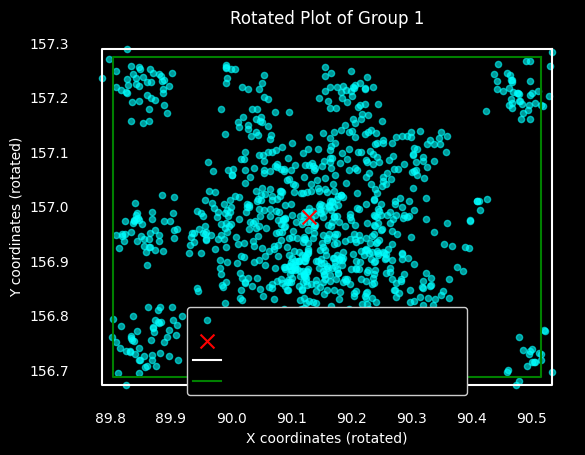

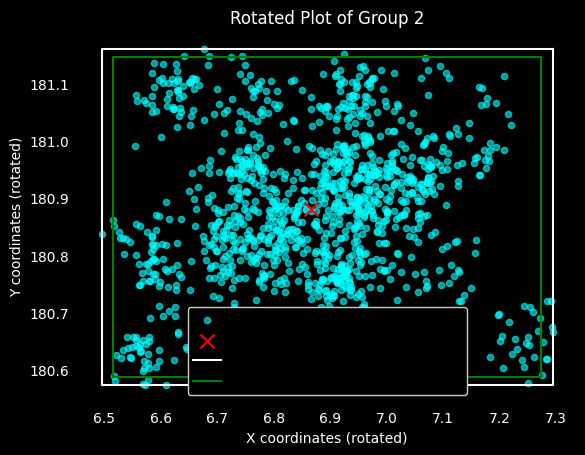

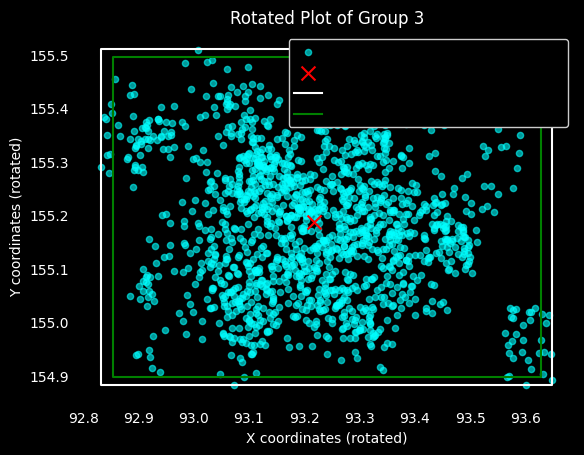

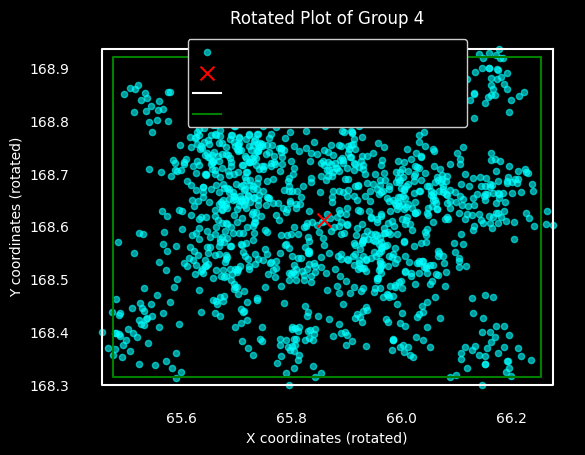

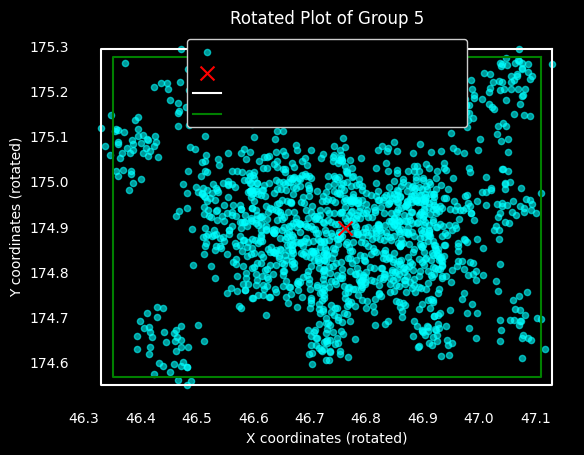

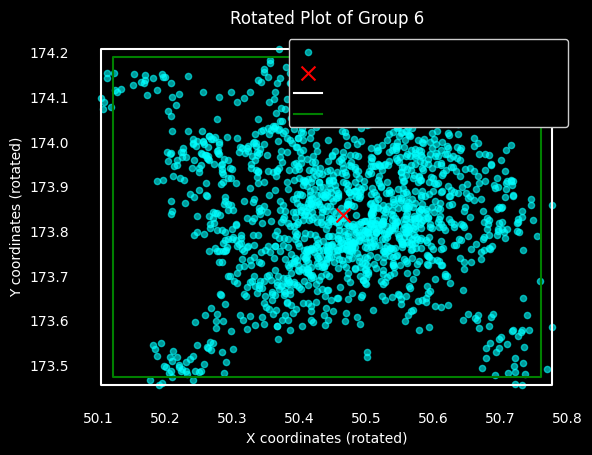

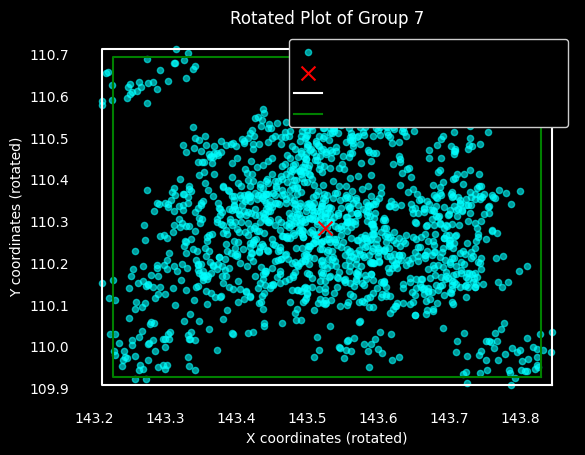

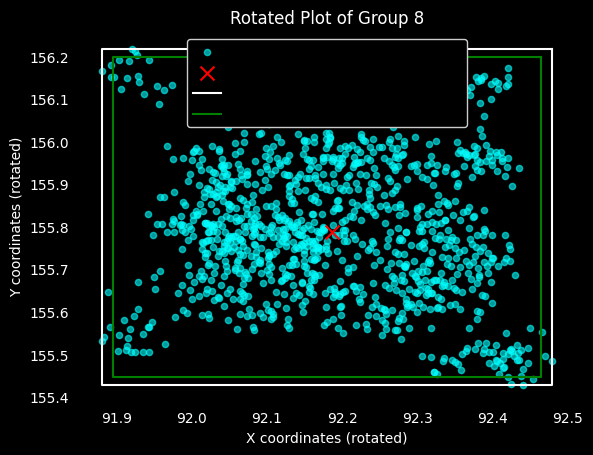

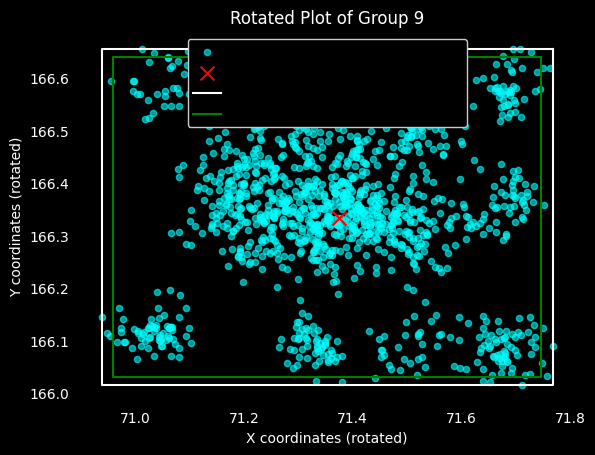

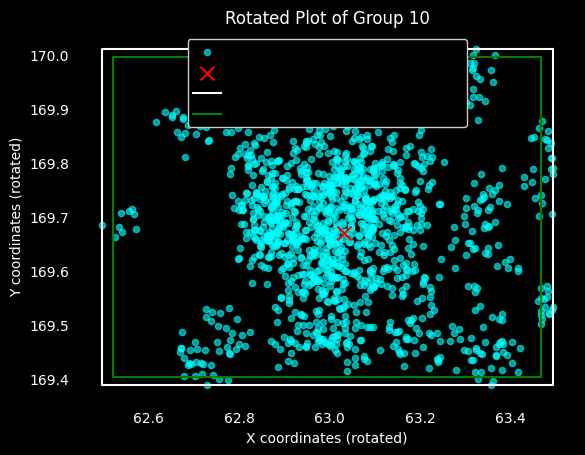

In [89]:
filename = "track_positive_ctrl_data/csDNA_Experiment5_t=14hr_100724_T1_cropped_locs_render_picked_avg.hdf5"
process_multiple_origami_track_population(filename=filename, k = 8)
